#### Example using DEMReg and SDO/AIA data
Here using synthetic SDO/AIA data for a single "pixel" generated from a Gaussian DEM 

And then does time series to create DEMograms and images to create DEM maps.

* 17-Aug-2020 IGH
* 03-Feb-2021 - Updated using new dn2dem_pos_selfnorm function
* 16-Jun-2021 - Updated to work with fixed dn2dem_pos, which can do selfnorm, gloci or user wght
* 16-Jun-2021 - Changed dn2dem_pos to now interp tresp in log-space
* 18-Jun-2021 - Added back in synthetic map demo (at end)
* 24-Nov-2021 - Tweaked response plot and plot 2d result
* 21-Jan-2022 - Expanded example on handling multiple dimension data
* 24-Jan-2022 - Added in multi-panel DEM map plotting example
* 30-Jan-2022 - Added in example of /noblend tresp
* 26-Apr-2022 - Checked worked with updated code
* 02-May-2022 - Tweaked import setup
* 14-Nov-2022 - Example removing a channel
* 17-Nov-2022 - Corrected labelling typo in DEM maps titles
* 26-Jun-2023 - Reran with numpy optimised for Apple silicon (x20-30 faster!)
* 24-Sep-2025 - Now working with numpy v2+

In [1]:
# Import some of the stuff we will need
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as io

# So can have single copy of demreg on system, and don't need copy in working directory
from sys import path as sys_path
# Change to your local copy's location...
sys_path.append('/home/hpcp31/demreg/python')
from dn2dem_pos import dn2dem_pos

import warnings
warnings.simplefilter('ignore')
matplotlib.rcParams['font.size'] = 16

In [2]:
# Load in the SSWIDL generated response functions
# Was produced by make_aiaresp_forpy.pro (can't escape sswidl that easily....)
trin=io.readsav('aia_tresp_en.dat')

# Get rid of the b in the string name (byte vs utf stuff....)
for i in np.arange(len(trin['channels'])):
    trin['channels'][i]=trin['channels'][i].decode("utf-8")
print(trin['channels'])

# Get the temperature response functions in the correct form for demreg
tresp_logt=np.array(trin['logt'])
nt=len(tresp_logt)
nf=len(trin['tr'][:])
trmatrix=np.zeros((nt,nf))
for i in range(0,nf):
    trmatrix[:,i]=trin['tr'][i]
matplotlib.rcParams['font.size'] = 16

['A94' 'A131' 'A171' 'A193' 'A211' 'A335']


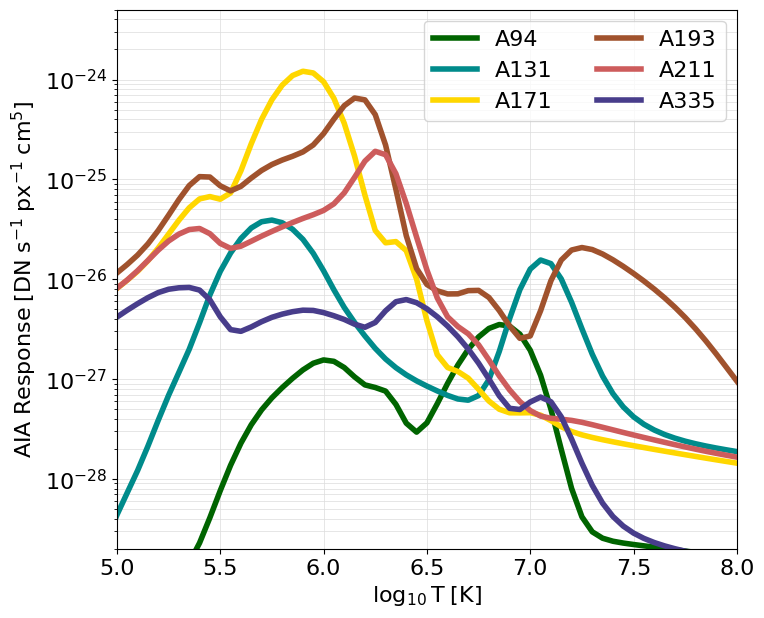

In [3]:
# Check the response look correct by plotting them
# Setup some AIA colours
clrs=['darkgreen','darkcyan','gold','sienna','indianred','darkslateblue']

# Do the plot
fig = plt.figure(figsize=(8, 7))
for i in np.arange(6):
    plt.semilogy(tresp_logt,trmatrix[:,i],label=trin['channels'][i],color=clrs[i],lw=4)
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{AIA\;Response\;[DN\;s^{-1}\;px^{-1}\;cm^5]}$')
plt.ylim([2e-29,5e-24])
plt.xlim([5.0,8.0])
plt.legend(ncol=2,prop={'size': 16})
plt.rcParams.update({'font.size': 16})
plt.grid(True,which='both',lw=0.5,color='gainsboro')
plt.show()

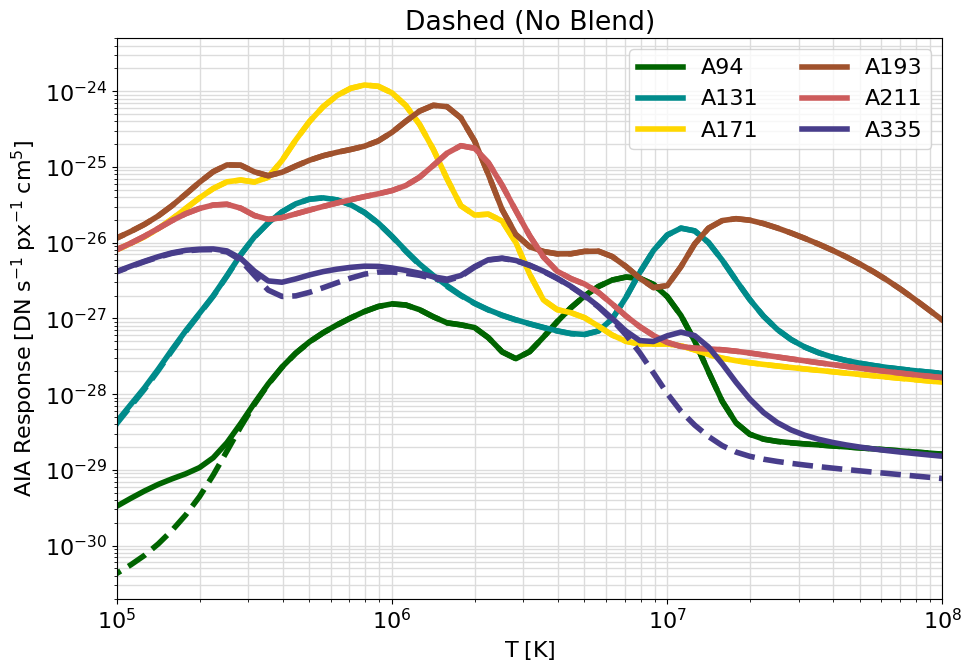

In [4]:
# Aside - above responses were calculated using the configuration in
# make_aiaresp_forpy.pro, other options/tweaks available such as /noblend, i.e.
trin_nb=io.readsav('aia_tresp_en_nb.dat')
fig = plt.figure(figsize=(10, 7))
for i in np.arange(6):
    plt.loglog(10**tresp_logt,trmatrix[:,i],label=trin['channels'][i],color=clrs[i],lw=4)
    plt.loglog(10**trin_nb['logt'],trin_nb['tr'][i],color=clrs[i],lw=4,ls='--')
plt.xlabel('$\mathrm{T\;[K]}$')
plt.ylabel('$\mathrm{AIA\;Response\;[DN\;s^{-1}\;px^{-1}\;cm^5]}$')
plt.ylim([2e-31,5e-24])
plt.xlim([1e5,1e8])
plt.title('Dashed (No Blend)')
plt.legend(ncol=2,prop={'size': 16})
plt.rcParams.update({'font.size': 16})
plt.grid(True,which='both',lw=1,color='gainsboro')
plt.tight_layout()
plt.savefig('tresp.pdf')
plt.show()

In [5]:
# For some DEM model (i.e. a Gaussian) produce the synthetic DN/s/px for each AIA channel
d1=4e22
m1=6.5
s1=0.15
root2pi=(2.*math.pi)**0.5
dem_mod=(d1/(root2pi*s1))*np.exp(-(tresp_logt-m1)**2/(2*s1**2))

# # Check what the DEM model looks like
# fig = plt.figure(figsize=(8, 4.5))
# plt.plot(tresp_logt,dem_mod)
# plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
# plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
# plt.ylim([2e20,4e23])
# plt.xlim([5.7,7.2])
# plt.rcParams.update({'font.size': 16})
# plt.yscale('log')
# plt.show()

# Now work out the DN/s/px
# For AIA responses all are dlogt=0.05
tresp_dlogt=np.full(nt,0.05)
tc_full=np.zeros([nt,nf])
for i in range(0,nf):
    tc_full[:,i]=dem_mod*trmatrix[:,i]*10**tresp_logt*np.log(10**tresp_dlogt)

dn_in=np.sum(tc_full,0)
print('dn_in: ',dn_in)

# And the associated uncertainty (no systematics)
gains=np.array([18.3,17.6,17.7,18.3,18.3,17.6])
dn2ph=gains*np.array([94,131,171,193,211,335])/3397.
rdnse=np.array([1.14,1.18,1.15,1.20,1.20,1.18])
# assume all obs were 2.9s long
dn0=dn_in*2.9
shotnoise=(dn2ph*dn0)**0.5/dn2ph/2.9
# error in DN/s/px
edn_in=(rdnse**2+shotnoise**2)**0.5 
print('edn_in: ',edn_in)

dn_in:  [  326.11015434   313.31711078  2663.51032758 11361.19773432
  8700.35614133  1208.36625462]
edn_in:  [14.94543538 12.67184957 32.12696435 61.39593311 51.38885685 15.53907416]


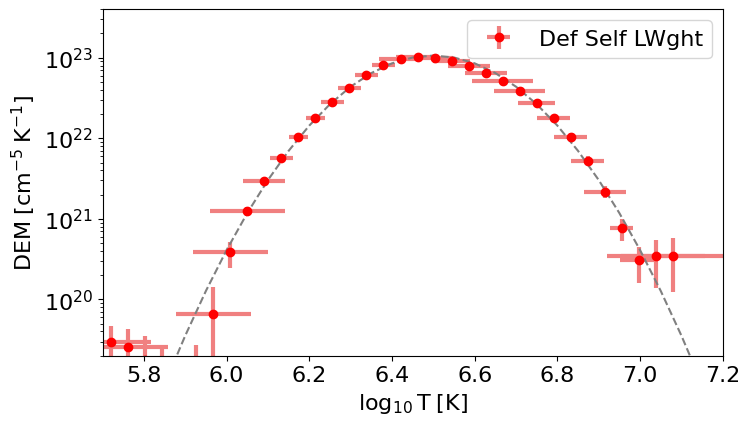

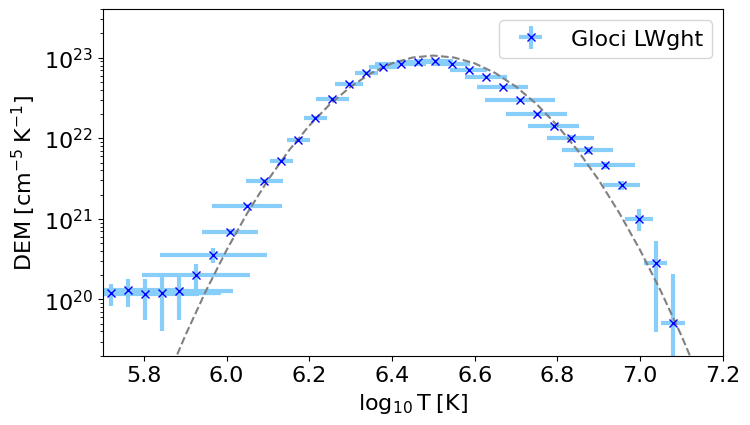

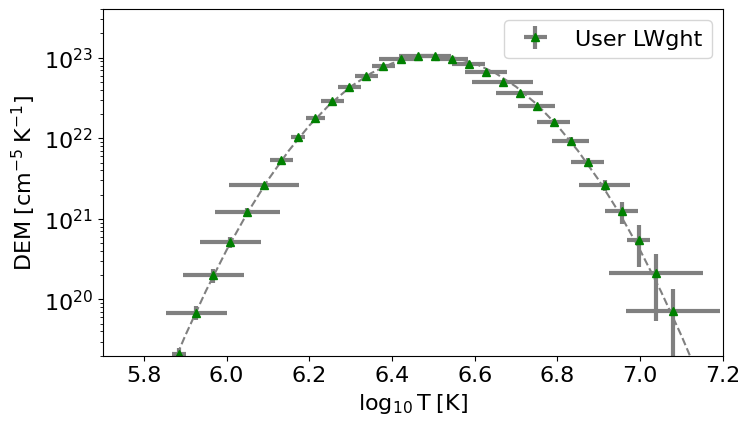

In [6]:
#  Setup the T binning for DEM solution
temps=np.logspace(5.7,7.1,num=35)
# Temperature bin mid-points for DEM plotting
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])

# Now work out the DEM - investigate 3 standard ways of running
# 1. Default - reg runs twice, 1st time to work out weight for constraint matrix, then regs with that
#         Best option if don't know what doing, hence its the default 
dem0,edem0,elogt0,chisq0,dn_reg0=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps) #gloci=0 is default behaviour
# 2. EMloci - reg runs once, works out weight for constraint matrix as min of EM Loci, then regs with that
#        If some of your filters have a sharper T response (lines or X-ray obs) might be useful to try
dem1,edem1,elogt1,chisq1,dn_reg1=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,gloci=1)
# 3. User weight - reg runs once, user provide weight for constraint matrix L, then regs with that
#         If have an idea of what DEM might look like could try a rough form of it (though check vs 1, 2 above)
# As working with synthetic data from DEM model, could try weighting by this model, interp on output DEM T bins
demwght0=10**np.interp(mlogt,tresp_logt,np.log10(dem_mod))
dem2,edem2,elogt2,chisq2,dn_reg2=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,dem_norm0=demwght0/max(demwght0))

#  Plot it all
yr=[2e19,4e23]
xr=[5.7,7.2]#np.log10([min(temps),max(temps)])
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem0,xerr=elogt0,yerr=edem0,fmt='or',\
             ecolor='lightcoral', elinewidth=3, capsize=0,label='Def Self LWght')
plt.plot(tresp_logt,dem_mod,'--',color='grey')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim(yr)
plt.xlim(xr)
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend()
# plt.savefig('demregpy_aiasyn_slw.png',bbox_inches='tight')
plt.show()

#  Plot it all
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem1,xerr=elogt1,yerr=edem1,fmt='xb',\
             ecolor='lightskyblue', elinewidth=3, capsize=0,label='Gloci LWght')
plt.plot(tresp_logt,dem_mod,'--',color='grey')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim(yr)
plt.xlim(xr)
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend()
# plt.savefig('demregpy_aiasyn_glw.png',bbox_inches='tight')
plt.show()

#  Plot it all
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem2,xerr=elogt2,yerr=edem2,fmt='^g',\
             ecolor='grey', elinewidth=3, capsize=0,label='User LWght')
plt.plot(tresp_logt,dem_mod,'--',color='grey')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim(yr)
plt.xlim(xr)
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend()
# plt.savefig('demregpy_aiasyn_ulw.png',bbox_inches='tight')
plt.show()


Def Self, chisq:  1.499170884368957
Gloci, chisq:  17.71848070411076
User, chisq:  1.0031927080670389
Def Self:  [0.97661496 0.99638963 1.00045578 0.99949086 0.99997065 0.96203406]
Gloci:  [0.89611548 1.01593808 1.00104442 1.00021599 0.98955926 0.87277232]
User:  [0.95069596 0.99672826 0.99947761 0.99954449 0.99969607 0.97169841]


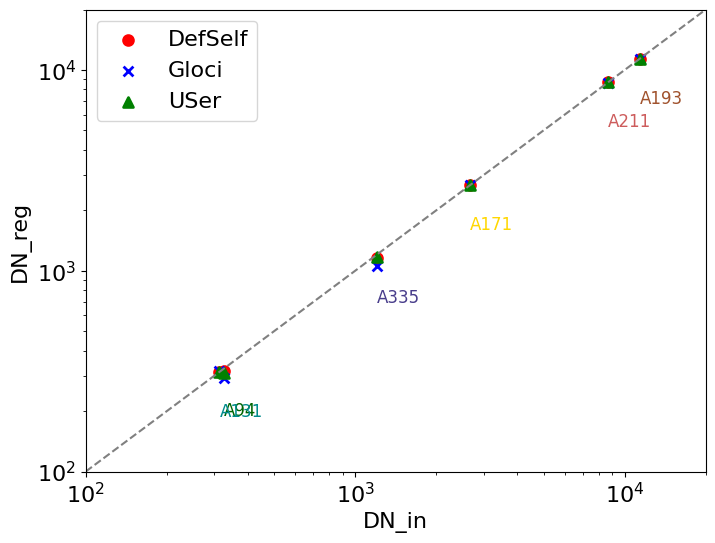

In [7]:
#  How well did they actually do?
print('Def Self, chisq: ',chisq0) # Not bad....
print('Gloci, chisq: ',chisq1) # Worse of 3 but expected as just working with AIA filters here
print('User, chisq: ',chisq2) # Know the answer so unsurprising this LWght gives best answer!

print('Def Self: ',dn_reg0/dn_in)
print('Gloci: ',dn_reg1/dn_in)
print('User: ',dn_reg2/dn_in)

fig,ax = plt.subplots(figsize=(8, 6))
plt.scatter(dn_in,dn_reg0,color='red',marker='o',s=50,lw=2,label='DefSelf')
plt.scatter(dn_in,dn_reg1,color='blue',marker='x',s=50,lw=2,label='Gloci')
plt.scatter(dn_in,dn_reg2,color='green',marker='^',s=50,lw=2,label='USer')
for i, lab in enumerate(trin['channels']):
    ax.annotate(lab, (dn_in[i], 0.6*dn_reg0[i]),color=clrs[i],fontsize=12)
plt.xlabel('DN_in')
plt.ylabel('DN_reg')
xyrang=[1e2,2e4]
plt.plot(xyrang,xyrang,color='grey',ls='dashed')
plt.ylim(xyrang)
plt.xlim(xyrang)
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

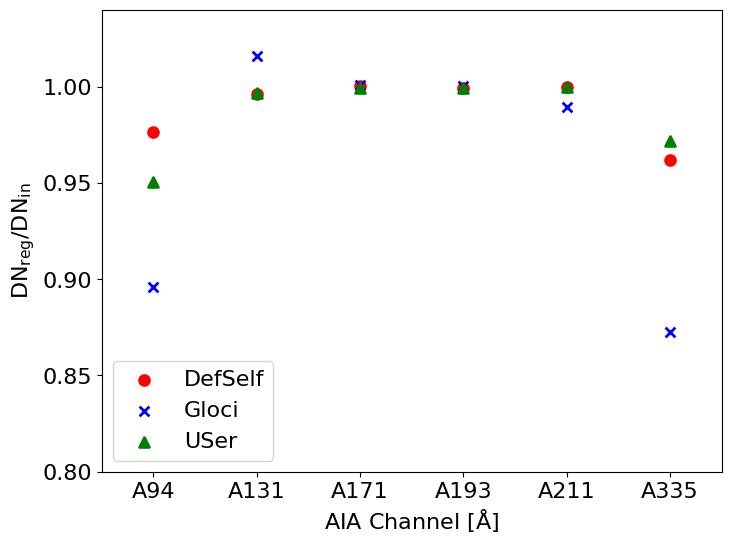

In [8]:
#  Or compare in terms of ratio
fig,ax = plt.subplots(figsize=(8, 6))
plt.scatter(np.arange(6),dn_reg0/dn_in,marker='o',color='red',s=50,lw=2,label='DefSelf')
plt.scatter(np.arange(6),dn_reg1/dn_in,marker='x',color='blue',s=50,lw=2,label='Gloci')
plt.scatter(np.arange(6),dn_reg2/dn_in,marker='^',color='green',s=50,lw=2,label='USer')
plt.ylim([0.80,1.04])
plt.xlim([-0.5,5.5])
plt.xticks(np.arange(6),trin['channels'])
plt.xlabel('AIA Channel [$\mathrm{\AA}$]')
plt.ylabel('DN$_\mathrm{reg}$/DN$_\mathrm{in}$')
plt.locator_params(axis='y', nbins=5)
plt.legend()
plt.show()

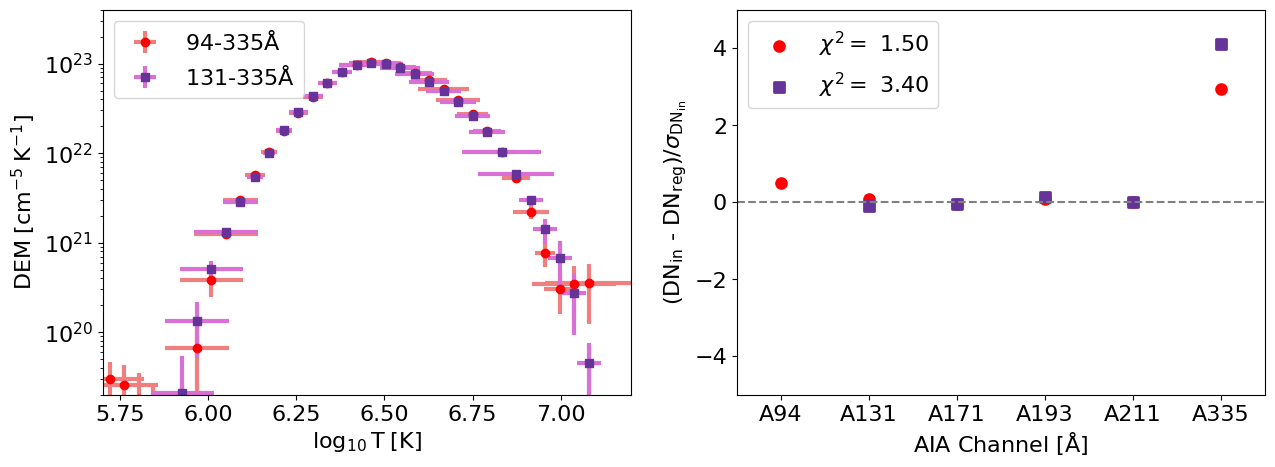

In [9]:
# 94 the worse so what happens if remove it?
dn_in5=dn_in[1:]
edn_in5=edn_in[1:]
trmatrix5=trmatrix[:,1:]

temps=np.logspace(5.7,7.1,num=35)
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])
dem05,edem05,elogt05,chisq05,dn_reg05=dn2dem_pos(dn_in5,edn_in5,trmatrix5,tresp_logt,temps)

fig= plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 16})

ax1 = fig.add_subplot(1, 2, 1)
plt.errorbar(mlogt,dem0,xerr=elogt0,yerr=edem0,fmt='or',\
             ecolor='lightcoral', elinewidth=3, capsize=0,label='94-335$\mathrm{\AA}$')
plt.errorbar(mlogt,dem05,xerr=elogt05,yerr=edem05,fmt='s',color='rebeccapurple',\
             ecolor='orchid', elinewidth=3, capsize=0,label='131-335$\mathrm{\AA}$')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
yr=[2e19,4e23]
xr=[5.7,7.2]
plt.ylim(yr)
plt.xlim(xr)
plt.legend()
plt.yscale('log')

ax2 = fig.add_subplot(1, 2, 2)
plt.scatter(np.arange(6),(dn_in-dn_reg0)/edn_in,marker='o',color='red',\
            s=50,lw=2,label='$\chi^2 =$ {:0.2f}'.format(chisq0))
plt.scatter(np.arange(5)+1,(dn_in5-dn_reg05)/edn_in5,marker='s',color='rebeccapurple',\
            s=50,lw=2,label='$\chi^2 =$ {:0.2f}'.format(chisq05))
plt.plot([-1,12],[0,0],'--',color='grey')
plt.ylim([-5,5])
plt.xlim([-0.5,5.5])
plt.xticks(np.arange(6),trin['channels'])
plt.xlabel('AIA Channel [$\mathrm{\AA}$]')
plt.ylabel('(DN$_\mathrm{in}$ - DN$_\mathrm{reg}$)/$\sigma_\mathrm{DN_{in}}$')
plt.locator_params(axis='y', nbins=5)
plt.legend()
plt.show()

# So although the DEM looks "better" in DN space actually worse, so maybe 335 is actually the problem?

Warning, positivity loop hit max iterations, so increase max_iter? Or rgt_fact too small?


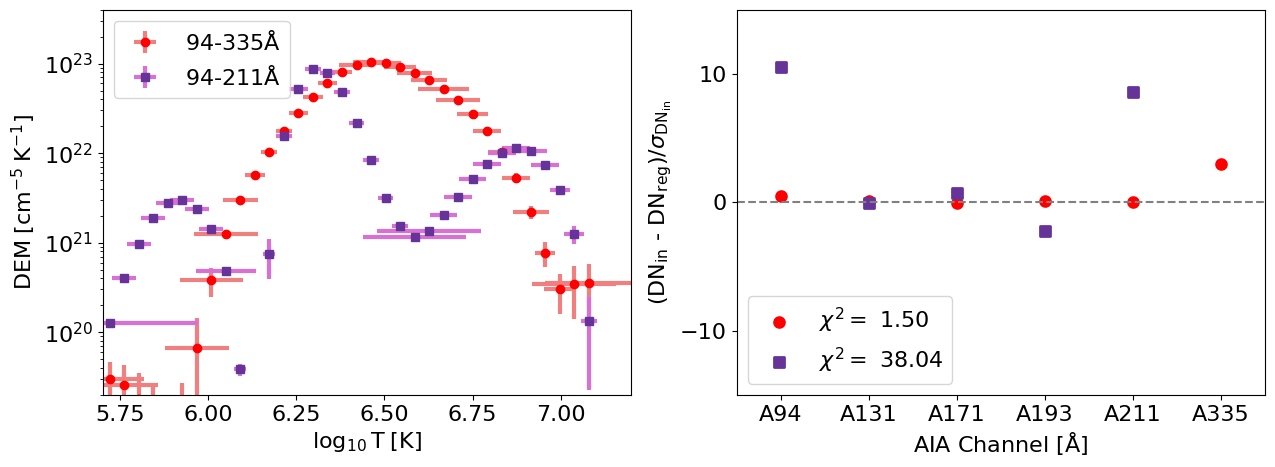

In [10]:
# Now try no 335?
dn_in5=dn_in[:-1]
edn_in5=edn_in[:-1]
trmatrix5=trmatrix[:,:-1]

temps=np.logspace(5.7,7.1,num=35)
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])
dem05,edem05,elogt05,chisq05,dn_reg05=dn2dem_pos(dn_in5,edn_in5,trmatrix5,tresp_logt,temps)

fig= plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 16})

ax1 = fig.add_subplot(1, 2, 1)
plt.errorbar(mlogt,dem0,xerr=elogt0,yerr=edem0,fmt='or',\
             ecolor='lightcoral', elinewidth=3, capsize=0,label='94-335$\mathrm{\AA}$')
plt.errorbar(mlogt,dem05,xerr=elogt05,yerr=edem05,fmt='s',color='rebeccapurple',\
             ecolor='orchid', elinewidth=3, capsize=0,label='94-211$\mathrm{\AA}$')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
yr=[2e19,4e23]
xr=[5.7,7.2]
plt.ylim(yr)
plt.xlim(xr)
plt.legend()
plt.yscale('log')

ax2 = fig.add_subplot(1, 2, 2)
plt.scatter(np.arange(6),(dn_in-dn_reg0)/edn_in,marker='o',color='red',\
            s=50,lw=2,label='$\chi^2 =$ {:0.2f}'.format(chisq0))
plt.scatter(np.arange(5),(dn_in5-dn_reg05)/edn_in5,marker='s',color='rebeccapurple',\
            s=50,lw=2,label='$\chi^2 =$ {:0.2f}'.format(chisq05))
plt.plot([-1,12],[0,0],'--',color='grey')
plt.ylim([-15,15])
plt.xlim([-0.5,5.5])
plt.xticks(np.arange(6),trin['channels'])
plt.xlabel('AIA Channel [$\mathrm{\AA}$]')
plt.ylabel('(DN$_\mathrm{in}$ - DN$_\mathrm{reg}$)/$\sigma_\mathrm{DN_{in}}$')
plt.locator_params(axis='y', nbins=5)
plt.legend()
plt.show()

# Nope, seems to like having 335 in there....

---

In [11]:
# # Now lets try making a 1D array (really 2D as t,f) from our synthetic pixel 
# # This could also be a map position-slice or pixel/region average changing with time

nt=12
# Only input data and error needs the extra dimensions here - TR resp and T binnings as before
dn_in2d=np.zeros([nt,nf])
edn_in2d=np.zeros([nt,nf])
for t in np.arange(nt):
# Giving some time dependance to our synthetic data so we can see the change in the DEMogram
# Obviously with real data you wouldn't need to do this
    dn_in2d[t,:]=dn_in*(1+(t*6.)/nt)
# Just use 10% for error as changed data - again with real data use the full error calculation
    edn_in2d[t,:]=0.1*dn_in
    
# Now do the DEMogram calculation    
dem1d,edem1d,elogt1d,chisq1d,dn_reg1d=dn2dem_pos(dn_in2d,edn_in2d,trmatrix,tresp_logt,temps)

# print('DN_reg: ',dn_reg1d[0,:])
# print('chisq: ',chisq1d[0])

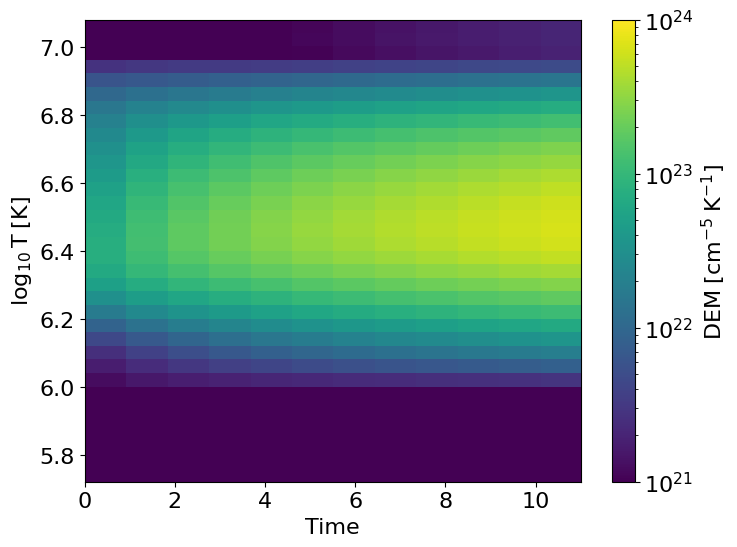

In [12]:
# Can plot t (or position) vs logT, producing a DEMogram
fig,ax = plt.subplots(figsize=(8, 6))
plt.imshow(dem1d.T,aspect='auto',origin='lower',norm=matplotlib.colors.LogNorm(vmin=1e21, vmax=1e24),\
           extent=[0,nt-1,min(mlogt),max(mlogt)])
plt.ylabel('$\mathrm{\log_{10}T\;[K]}$')
plt.xlabel('Time')
plt.colorbar(label='$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.show()

#  A vertical slice of the below plot would give the standard DEM plot of DEM vs logT

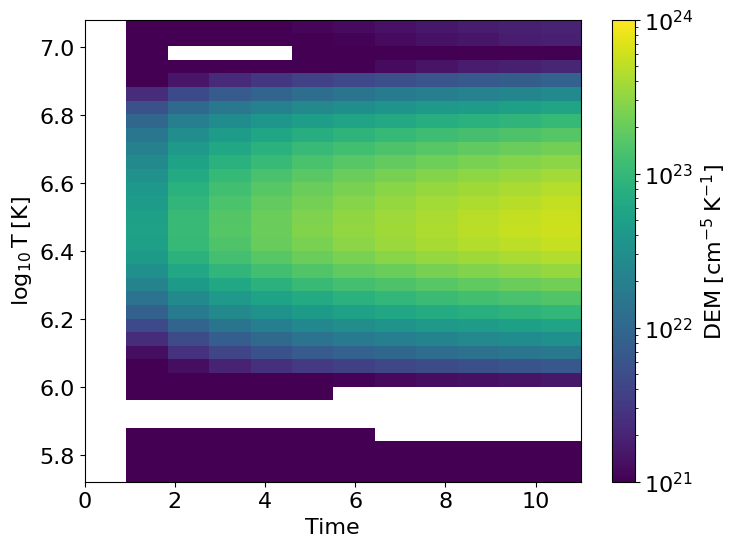

In [13]:
# Might help to subtract the DEM from the first time to see how things are changing

dem1d_bs=(dem1d-dem1d[0,:])

fig,ax = plt.subplots(figsize=(8, 6))
plt.imshow(dem1d_bs.T,aspect='auto',origin='lower',\
           # If subtraction then might be some -ve, so Log scale not best?
           # norm=matplotlib.colors.Normalize(vmin=1e21, vmax=1e24),\
           norm=matplotlib.colors.LogNorm(vmin=1e21, vmax=1e24),\
           extent=[0,nt-1,min(mlogt),max(mlogt)])
plt.ylabel('$\mathrm{\log_{10}T\;[K]}$')
plt.xlabel('Time')
plt.colorbar(label='$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.show()


In [19]:
# # Now lets try making a 2D array (really 3D as x,y,f) from our synthetic pixel 
# # to test speed of the code with a AIA "maps":
# # If lot's of data code automatically runs in parallel instead of serial

nx=200
ny=200
# Only input data and error needs the extra dimensions here - TR resp and T binnings as before
dn_in2d=np.zeros([nx,ny,nf])
edn_in2d=np.zeros([nx,ny,nf])


for y in np.arange(ny):
    for x in np.arange(nx):
        # Giving some x,y dependance to our synthetic data so we can see the change in the DEM maps
        # Obviously with real data you wouldn't need to do this
        dn_in2d[x,y,:]=dn_in *(1+(y*1.5/ny)+(x*2./nx))
        # Just use 10% for error as changed data - again with real data use the full error calculation
        edn_in2d[x,y,:]=0.1*dn_in 
        
#  Do slightly differnt binning for these DEMs
t_space=0.05
t_min=5.6
t_max=7.4
logtemps=np.linspace(t_min,t_max,num=int((t_max-t_min)/t_space)+1)
temps=10**logtemps

import cProfile

def run_dem():
    return dn2dem_pos(dn_in5, edn_in5, trmatrix5, tresp_logt, temps)

# Warm up
for _ in range(3): 
    _ = run_dem()

# Time it
%timeit run_dem()

# Run profiler
cProfile.run('run_dem()', 'profile_output_syn.prof')
        
# Now do the DEM maps calculation           
dem2d,edem2d,elogt2d,chisq2d,dn_reg2d=dn2dem_pos(dn_in2d,edn_in2d,trmatrix,tresp_logt,temps)


Warning, positivity loop hit max iterations, so increase max_iter? Or rgt_fact too small?
Warning, positivity loop hit max iterations, so increase max_iter? Or rgt_fact too small?
Warning, positivity loop hit max iterations, so increase max_iter? Or rgt_fact too small?
Warning, positivity loop hit max iterations, so increase max_iter? Or rgt_fact too small?
Warning, positivity loop hit max iterations, so increase max_iter? Or rgt_fact too small?
Warning, positivity loop hit max iterations, so increase max_iter? Or rgt_fact too small?
Warning, positivity loop hit max iterations, so increase max_iter? Or rgt_fact too small?
Warning, positivity loop hit max iterations, so increase max_iter? Or rgt_fact too small?
Warning, positivity loop hit max iterations, so increase max_iter? Or rgt_fact too small?
Warning, positivity loop hit max iterations, so increase max_iter? Or rgt_fact too small?
Warning, positivity loop hit max iterations, so increase max_iter? Or rgt_fact too small?
Warning, p

100%|██████████| 400/400 [00:02<00:00, 138 x10^2 DEM/s]  


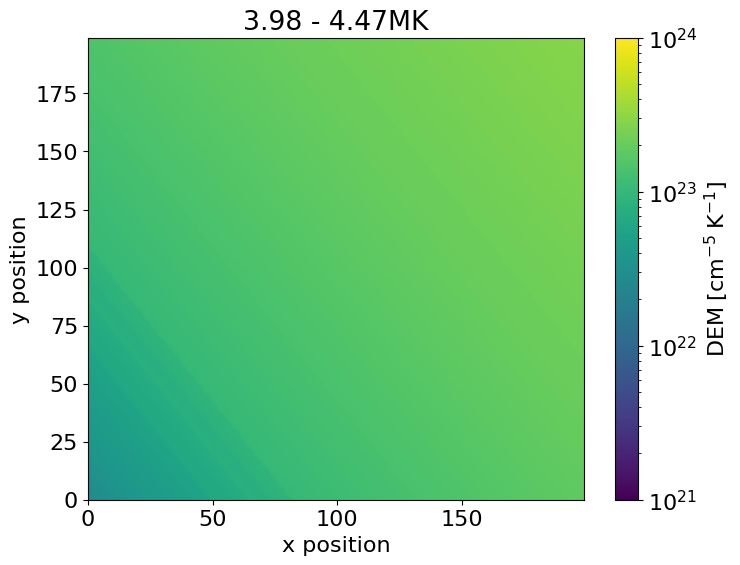

In [18]:
# Can now plot DEM maps - DEM as a function of x,y for some chosen logT range
t_id=20
fig,ax = plt.subplots(figsize=(8, 6))
plt.imshow(dem2d[:,:,t_id].T,aspect='auto',origin='lower',norm=matplotlib.colors.LogNorm(vmin=1e21, vmax=1e24),\
           extent=[0,nx-1,0,ny-1])
plt.ylabel('y position')
plt.xlabel('x position')

plt.title(f'{temps[t_id]*1e-6:.2f} - {temps[t_id+1]*1e-6:.2f}MK')
plt.colorbar(label='$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.show()


In [ ]:
#  Too many T bins to show easily so combine every, say 4, together
nt=len(dem2d[0,0,:])
nt_new=int(nt/4)

# And make a nice final plot
plt.rcParams.update({'font.size': 16,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})

fig,axs = plt.subplots(3,3,figsize=(12,8))

for i in range(nt_new):
    xid=math.floor(i/3)
    yid=i%3
    new_dem2d=(dem2d[:,:,i*4]+dem2d[:,:,i*4+1]+dem2d[:,:,i*4+2]+dem2d[:,:,i*4+3])/4.
    im=axs[xid,yid].imshow(np.log10(new_dem2d),origin='lower',vmin=19,vmax=24,cmap='inferno',aspect='auto')
    axs[xid,yid].set_title(f'log T: {logtemps[i*4]:.2f} - {logtemps[i*4+3+1]:.2f}')
    axs[xid,yid].set_xticks([])
    axs[xid,yid].set_yticks([])
    
fig.colorbar(im, ax=axs.ravel().tolist(),label='$\mathrm{log_{10}\;DEM\;[cm^{-5}\;K^{-1}]}$',fraction=0.03, pad=0.02)
plt.show()   